In [1]:
#-1 Utility
import pandas as pd #dataframe
import numpy as np #Linear algebra
import matplotlib.pyplot as plt #plotting
import seaborn as sns 
import re #regular expression


pd.set_option("display.max_columns", None)

In [2]:
#Part 00: Input:
dataset= pd.read_csv("/Users/abdallaalia/Jypyter/Titanic/train.csv")

In [3]:
print(dataset.columns)
print(dataset.head())

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0

In [4]:
#Part 00.01: pre-analysis.
#We see that the feature "Name" does not depend on the dataset, albeit there exists "Titles" which are.
#In particular, the title occurs after a ", " and before a ".". Finally, we remap by groupby.
dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
title_dictionary = {"Miss": 1, 
                    "Mrs": 2, 
                    "Master": 3, 
                    "Mr": 4}
dataset['Title']= dataset['Title'].map(title_dictionary)
#We identified these four cells as the most frequent, the others are being NA afterwards.
title_other= 0
dataset['Title'].fillna(title_other,inplace=True)

#We drop the feutures "Ticket", since it contains high ratio of duplicates
#We drop the feutures "Cabin", since it contain high ratio of null-values
#We drop the feutures "Name" and "PassengerId", since they should have no dependence on the dataset

dataset= dataset.drop(['Name', 'Cabin', 'PassengerId', 'Ticket'], 1)

print(dataset.columns)

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Title'],
      dtype='object')


In [5]:
# Part 01: Initial analysis:

#Part 01.01. analysis via desciptive data.

#Setting the parameters
features_with_na = [features for features in dataset.columns if dataset[features].isnull().sum()>1]
numerical_with_nan=[feature for feature in dataset.columns if dataset[feature].isnull().sum()>1 and dataset[feature].dtypes!='O']
numerical_features = [feature for feature in dataset.columns if dataset[feature].dtypes != 'O']
categorical_features=[feature for feature in dataset.columns if dataset[feature].dtypes=='O']
year_feature = [feature for feature in numerical_features if 'Yr' in feature or 'Year' in feature]
discrete_feature=[feature for feature in numerical_features if len(dataset[feature].unique())<25 and feature not in year_feature+['id']]
continuous_feature=[feature for feature in numerical_features if feature not in discrete_feature+year_feature+['id']]

print("The feutures with NA values are:" ,features_with_na,  "\n")
for feature in features_with_na:
    print(feature, np.round(dataset[feature].isnull().mean(), 4),  ' % missing values')
print("The categorical_features are:" ,categorical_features,  "\n")
for feature in categorical_features:
    print('The feature is {} and number of categories are {}'.format(feature,len(dataset[feature].unique())))
print('Number of numerical variables: ', len(numerical_features), "\n")
print("temporal features are", year_feature, "\n")
print("Discrete Variables Count: {}".format(len(discrete_feature)), "\n")
print("Continuous feature Count {}".format(len(continuous_feature)),  "\n")

The feutures with NA values are: ['Age', 'Embarked'] 

Age 0.1987  % missing values
Embarked 0.0022  % missing values
The categorical_features are: ['Sex', 'Embarked'] 

The feature is Sex and number of categories are 2
The feature is Embarked and number of categories are 4
Number of numerical variables:  7 

temporal features are [] 

Discrete Variables Count: 5 

Continuous feature Count 2 



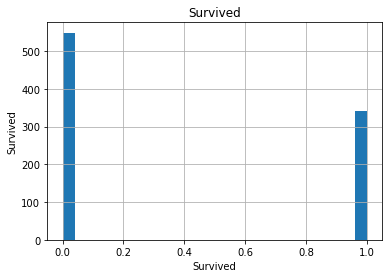

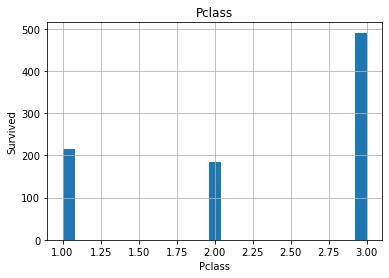

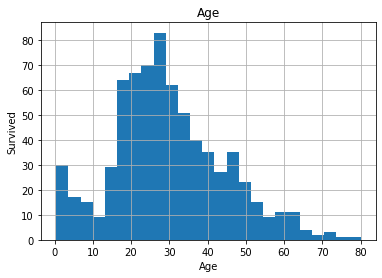

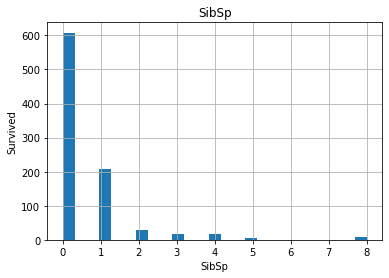

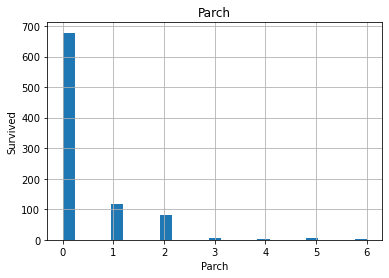

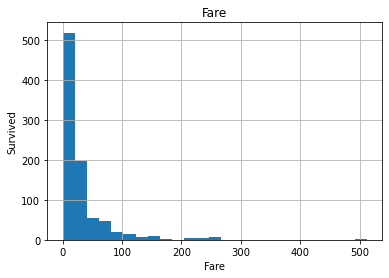

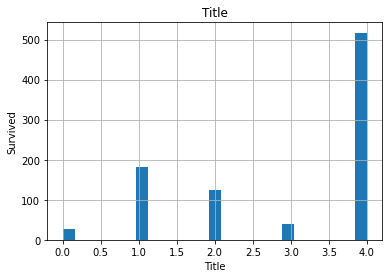

In [6]:
#Part 01.02: analysis via visualizing data.

for feature in numerical_features:
    data=dataset.copy()
    data[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel('Survived')
    plt.title(feature)
    plt.show()

In [7]:
#Part 02: Feauture prep:
#Missing values fix (numerical)
for feature in numerical_with_nan:
    median_value=dataset[feature].median()
    dataset[feature].fillna(median_value,inplace=True)
    
#Missing values fix (categorical)
for feature in categorical_features:
    freq_value= dataset[feature].dropna().mode()[0]
    dataset[feature].fillna(freq_value,inplace=True)

    
#Categorical labeling
for feature in categorical_features:
    labels_ordered=dataset.groupby([feature])['Survived'].mean().sort_values().index
    labels_ordered={k:i for i,k in enumerate(labels_ordered,0)}
    dataset[feature]=dataset[feature].map(labels_ordered)

In [8]:
#Feature scale
from sklearn.preprocessing import MinMaxScaler

feature_scale=[feature for feature in dataset.columns if feature not in ['Survived']]
scaler=MinMaxScaler()
scaler.fit(dataset[feature_scale])
scaler.transform(dataset[feature_scale])

dataset = pd.concat([dataset[['Survived']].reset_index(drop=True),
                    pd.DataFrame(scaler.transform(dataset[feature_scale]), columns=feature_scale)],
                    axis=1)

In [9]:
#Part 03: Building the pipeline.

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from lightgbm import LGBMClassifier

predict= "Survived"

X = np.array(dataset.drop([predict], 1))
y = np.array(dataset[predict])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

#Pipeline buiding:
pipeline_LR = Pipeline([('scalar1',StandardScaler()),
                     ('pca1',PCA(n_components=2)),
                     ('lr_classifier',LogisticRegression(random_state=42))])
pipeline_DTC = Pipeline([('scalar2',StandardScaler()),
                     ('pca2',PCA(n_components=2)),
                     ('lr_classifier',DecisionTreeClassifier(random_state=42))])
pipeline_RFC = Pipeline([('scalar3',StandardScaler()),
                     ('pca3',PCA(n_components=2)),
                     ('lr_classifier',RandomForestClassifier(random_state=42))])
pipeline_KNC = Pipeline([('scalar4',StandardScaler()),
                     ('pca4',PCA(n_components=2)),
                     ('lr_classifier',KNeighborsClassifier(n_neighbors=3))])
pipeline_GBC = Pipeline([('scalar5',StandardScaler()),
                     ('pca5',PCA(n_components=2)),
                     ('lr_classifier',GradientBoostingClassifier(random_state=42))])
pipeline_SVC = Pipeline([('scalar6',StandardScaler()),
                     ('pca6',PCA(n_components=2)),
                     ('lr_classifier',SVC(random_state=42))])
pipeline_LGBM = Pipeline([('scalar7',StandardScaler()),
                     ('pca7',PCA(n_components=2)),
                     ('lr_classifier',LGBMClassifier(random_state=42))])

pipelines = [pipeline_LR, pipeline_DTC, pipeline_RFC, pipeline_KNC, pipeline_GBC, pipeline_SVC, pipeline_LGBM]

# Pipeline parameter definittion
best_accuracy = 0.0
best_classifier = 0
best_pipeline = ""

pipe_dict = {0: 'Logistic Regression', 
             1: 'Decision Tree', 
             2: 'RandomForest', 
             3: 'KNeighborsClassifier', 
             4: 'GradientBoostingClassifier', 
             5: 'SVC',
             6: 'LGBM'
            }

for pipe in pipelines:
	pipe.fit(X_train, y_train)

# Gives Accuracy of all piplelines
for i,model in enumerate(pipelines):
    print("{} Test Accuracy: {}".format(pipe_dict[i],round(model.score(X_test,y_test)*100, 5)))

# Sorts by Accuracy
for i,model in enumerate(pipelines):
    if model.score(X_test,y_test) > best_accuracy:
        best_accuracy = model.score(X_test,y_test)
        best_pipeline = model
        best_classifier = i
print('Classifier with best accuracy:{}'.format(pipe_dict[best_classifier]))

Logistic Regression Test Accuracy: 77.77778
Decision Tree Test Accuracy: 80.0
RandomForest Test Accuracy: 82.22222
KNeighborsClassifier Test Accuracy: 78.88889
GradientBoostingClassifier Test Accuracy: 84.44444
SVC Test Accuracy: 78.88889
LGBM Test Accuracy: 77.77778
Classifier with best accuracy:GradientBoostingClassifier


In [10]:
#Parameters hyper tuning and cross validation.

from sklearn.model_selection import GridSearchCV

classifier = GradientBoostingClassifier()
parameters = {
    "n_estimators":[5,50,250,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
}

grid_search = GridSearchCV(estimator = classifier, 
                           param_grid = parameters, 
                           scoring = 'accuracy', 
                           cv = 5, 
                           n_jobs = -1)

grid_search = grid_search.fit(X_train, y_train)

newaccuracy = grid_search.best_score_
print("The optimal accuracy is:", grid_search.best_score_)
print("The best set of parameters is:", grid_search.best_params_)

The optimal accuracy is: 0.8327173913043477
The best set of parameters is: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
